# Collaboration


In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "multi-agent: collaboration"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from datetime import datetime


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}"
                " Today is {today}.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(today=datetime.today())
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [3]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

api_wrapper = DuckDuckGoSearchAPIWrapper(region="tw-tzh", max_results=5)
duckduckgo_search = DuckDuckGoSearchResults(api_wrapper=api_wrapper)

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Graph


#### State


In [4]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

#### Agent Node


In [5]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool, duckduckgo_search],
    system_message="Provide accurate data and generate Python code for the chart. This shall NOT be the final answer.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

#### Tool


In [6]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, duckduckgo_search, python_repl]
tool_node = ToolNode(tools)

#### Edge


In [7]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

#### Graph


In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "researcher": "researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("researcher")
graph = workflow.compile()

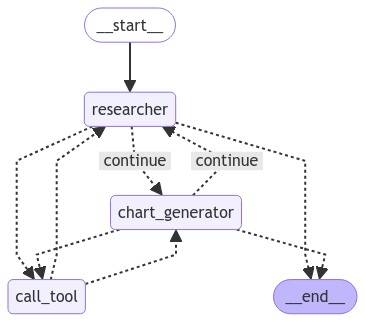

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke


message: Based on recent news and historical performance of Bitcoin, predict its price for the next three years and generate a price projection chart.
================================== Ai Message ==================================
Name: researcher
Tool Calls:
  tavily_search_results_json (call_Pq5aCWm3HQ64q7wO9N4GWxRB)
 Call ID: call_Pq5aCWm3HQ64q7wO9N4GWxRB
  Args:
    query: Bitcoin price prediction news September 2024
  duckduckgo_results_json (call_gESgIz187FXfO3vsfsXMIbhg)
 Call ID: call_gESgIz187FXfO3vsfsXMIbhg
  Args:
    query: Bitcoin historical price performance
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: The live Bitcoin price today is $58,033.65 USD with a 24-hour trading volume of $26,990,016,534.89 USD. We update our BTC to USD price in real-time., title: Bitcoin price today, BTC to USD live price, marketcap and chart ..., link: https://coinmarketcap.com/currencies/bitcoin/historical-data/, snip

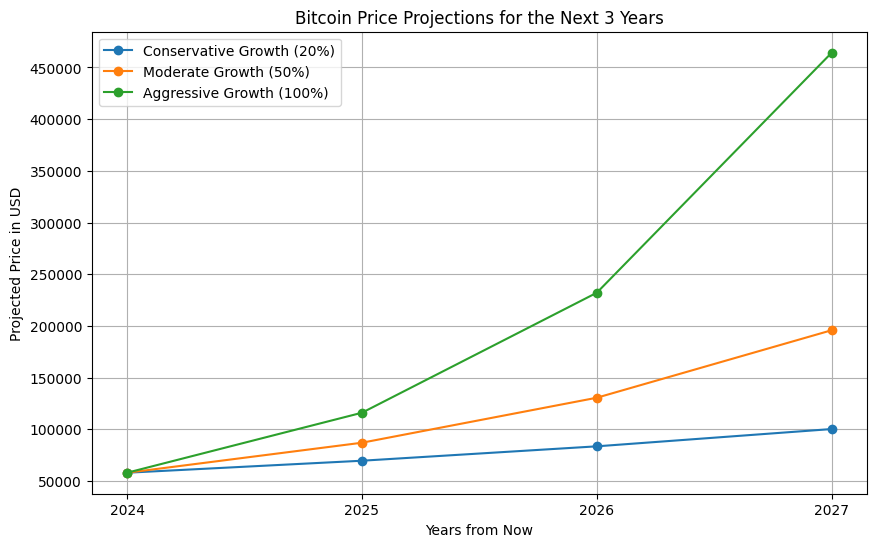

================================== Ai Message ==================================
Name: chart_generator
Tool Calls:
  python_repl (call_HqGrNYmjY26oojYDLBaDywAQ)
 Call ID: call_HqGrNYmjY26oojYDLBaDywAQ
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

# Current price of Bitcoin
current_price = 58033.65

# Years for projection
years = np.array([0, 1, 2, 3])
# Price projections for different growth scenarios
conservative_growth = [current_price, current_price * 1.20, current_price * 1.20**2, current_price * 1.20**3]
moderate_growth = [current_price, current_price * 1.50, current_price * 1.50**2, current_price * 1.50**3]
aggressive_growth = [current_price, current_price * 2.00, current_price * 2.00**2, current_price * 2.00**3]

# Plotting the price projections
plt.figure(figsize=(10, 6))
plt.plot(years, conservative_growth, label='Conservative Growth (20%)', marker='o')
plt.plot(years, moderate_growth, label='Moderate Growth (50%)', marker='o')
plt.plot(years, aggressiv

In [13]:
# question = "Based on Taiwan's GDP over the past 5 years, predict the next 3 years and generate a line chart."
# question = "Based on the news of Apple (AAPL), predict the next 3 years and generate a line chart."
question = "Based on recent news and historical performance of Bitcoin, predict its price for the next three years and generate a price projection chart."
events = graph.stream(
    {"messages": [question]},
    config={"recursion_limit": 50},  # Maximum number of steps to take in the graph
    stream_mode="values",
)


for event in events:
    last_message = event["messages"][-1]
    if isinstance(last_message, str):
        print(f"message: {last_message}")
    else:
        event["messages"][-1].pretty_print()